In [148]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.python.keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt

In [155]:
DIR = './short_projects/Unsupervised/wine/'

red = pd.read_csv(DIR+'winequality-red.csv')
red['is_red'] = 1
white = pd.read_csv(DIR+'winequality-white.csv')
white['is_red'] = 0

data = pd.concat([red, white], ignore_index=True)
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,0
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,0
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,0


In [156]:
train, test = train_test_split(data, train_size=0.6)
test, val = train_test_split(test, train_size=0.5)
train.shape, val.shape, test.shape

((3898, 13), (1300, 13), (1299, 13))

In [157]:
def get_y(df):
    return [df.pop('quality').to_numpy(), df.pop('is_red').to_numpy()]

def standardize(df):
    return StandardScaler().fit_transform(df)

In [158]:
y_train = get_y(train)
y_val = get_y(val)
y_test = get_y(test)

X_train = standardize(train)
X_val = standardize(val)
X_test = standardize(test)

In [209]:
def get_base_model(inputs):
    x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)
    x = tf.keras.layers.Dense(8, activation=tf.nn.relu)(x)
    return x

def get_model():
    inputs = tf.keras.layers.Input(shape=(11, ))
    x = get_base_model(inputs)
    quality = tf.keras.layers.Dense(1, name='quality')(x)
    type = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, name='type')(x)
    return tf.keras.models.Model(inputs=inputs, outputs=[quality, type])

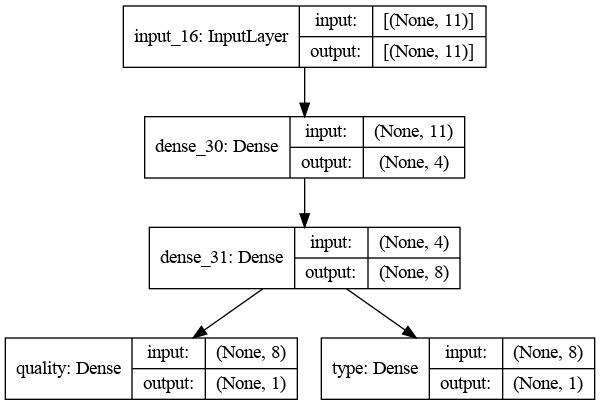

In [210]:
model = get_model()
plot_model(model, show_shapes=True)

In [211]:
opt = tf.keras.optimizers.Adam()
loss_q = tf.keras.losses.MeanSquaredError()
loss_t = tf.keras.losses.BinaryCrossentropy()

model.compile(
    optimizer=opt,
    loss = {
        'quality': loss_q,
        'type': loss_t
    },
    metrics = {
        'quality': tf.keras.metrics.RootMeanSquaredError(),
        'type': 'accuracy'
    }
)

In [212]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=0)

Epoch 1/10
122/122 [==============================] - 1s 3ms/step - loss: 26.1361 - quality_loss: 25.3259 - type_loss: 0.8102 - quality_root_mean_squared_error: 5.0325 - type_accuracy: 0.2694 - val_loss: 19.3559 - val_quality_loss: 18.5962 - val_type_loss: 0.7597 - val_quality_root_mean_squared_error: 4.3123 - val_type_accuracy: 0.3238
Epoch 2/10
122/122 [==============================] - 0s 2ms/step - loss: 12.1790 - quality_loss: 11.5580 - type_loss: 0.6209 - quality_root_mean_squared_error: 3.3997 - type_accuracy: 0.6765 - val_loss: 6.8206 - val_quality_loss: 6.3431 - val_type_loss: 0.4774 - val_quality_root_mean_squared_error: 2.5186 - val_type_accuracy: 0.8938
Epoch 3/10
122/122 [==============================] - 0s 1ms/step - loss: 5.4445 - quality_loss: 5.0611 - type_loss: 0.3834 - quality_root_mean_squared_error: 2.2497 - type_accuracy: 0.9236 - val_loss: 4.2770 - val_quality_loss: 3.9596 - val_type_loss: 0.3174 - val_quality_root_mean_squared_error: 1.9899 - val_type_accuracy:

In [213]:
history.history.keys()

dict_keys(['loss', 'quality_loss', 'type_loss', 'quality_root_mean_squared_error', 'type_accuracy', 'val_loss', 'val_quality_loss', 'val_type_loss', 'val_quality_root_mean_squared_error', 'val_type_accuracy'])

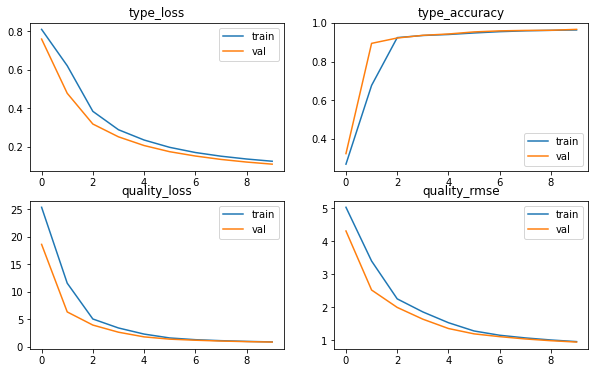

In [214]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(history.history['type_loss'])
plt.plot(history.history['val_type_loss'])
plt.title('type_loss')
plt.legend(['train', 'val'])

plt.subplot(2, 2, 2)
plt.plot(history.history['type_accuracy'])
plt.plot(history.history['val_type_accuracy'])
plt.title('type_accuracy')
plt.legend(['train', 'val'])

plt.subplot(2, 2, 3)
plt.plot(history.history['quality_loss'])
plt.plot(history.history['val_quality_loss'])
plt.title('quality_loss')
plt.legend(['train', 'val'])

plt.subplot(2, 2, 4)
plt.plot(history.history['quality_root_mean_squared_error'])
plt.plot(history.history['val_quality_root_mean_squared_error'])
plt.title('quality_rmse')
plt.legend(['train', 'val'])

plt.show()

In [215]:
model.evaluate(X_test, y_test)

41/41 [==============================] - 0s 936us/step - loss: 1.0088 - quality_loss: 0.8864 - type_loss: 0.1224 - quality_root_mean_squared_error: 0.9415 - type_accuracy: 0.9677


[1.008753776550293,
 0.8863860964775085,
 0.12236782908439636,
 0.941480815410614,
 0.9676674604415894]

In [225]:
pred_q, pred_t = model.predict(X_test)

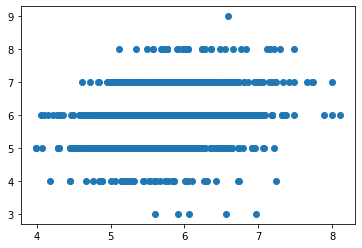

In [226]:
plt.scatter(pred_q, y_test[0])

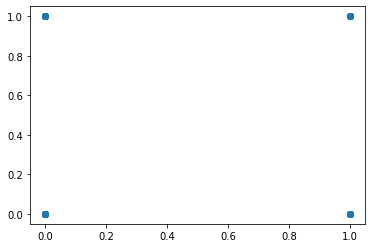